In [19]:
# Import the necessary information
%store -r crowley_gdf site_dir data_dir

In [20]:
### Import necessary packages
import earthaccess

### Reproducable file paths
import os
from glob import glob
import pathlib

### Managing spatial data
import geopandas as gpd
import xrspatial
import xarray as xr
import rioxarray
import rioxarray.merge as rxrmerge


### Managing other types of data
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rmrm
from math import floor, ceil
import matplotlib.pyplot as plt
from rasterio.merge import merge as merge_arrays
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rioxarray.merge import merge_arrays


### Manage invalid geometries
from shapely.geometry import MultiPolygon, Polygon

### Visualizing data
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

from math import floor, ceil
import matplotlib.pyplot as plt

import warnings






## Soil Data
Soil data was drawn from the POLARIS Database hosted at Duke University. The data repository can be found [here]() 

#Variable - Description,Units
* silt - silt percentage, %
* sand - sand percentage, %
* clay - clay percentage, %
* bd - bulk density, g/cm3
* theta_s - saturated soil water content, m3/m3
* theta_r - residual soil water content, m3/m3
* ksat - saturated hydraulic conductivity, log10(cm/hr)
* ph - soil pH in H2O, N/A
* om - organic matter, log10(%)
* lambda - pore size distribution index (brooks-corey), N/A
* hb - bubbling pressure (brooks-corey), log10(kPa)
* n - measure of the pore size distribution (van genuchten), N/A
*alpha - scale parameter inversely proportional to mean pore diameter (van genuchten), log10(kPa-1)

#Depth from surface
1. 0-5 cm
2. 5-15 cm
3. 15-30 cm
4. 30-60 cm
5. 60-100 cm
6. 100-200 cm

#Statistics provided per layer and variable:
1. mean - Arithmetic mean
1. mode - Mode
1. p50 - Median
1. p5 - 5th percentile
1. p95 - 95th percentile

#Resolutions
1. 1 arcsec (~30 meters)

Kentucky Coffee Trees can survive in a wide variety of soils, but do slightly better in sandy loam. Loam is soil composed mostly of sand, silt, and a smaller amount of clay. By weight, its mineral composition is about 40–40–20% concentration of sand–silt–clay, respectively. They also prefer a neutral ph. They have very deep roots, averaging 10-15 feet and wide bases often extending beyond their canopy. This is why they are so drought tolerant

20% sand 30% clay 70% silt

OPENED 
CROPPED


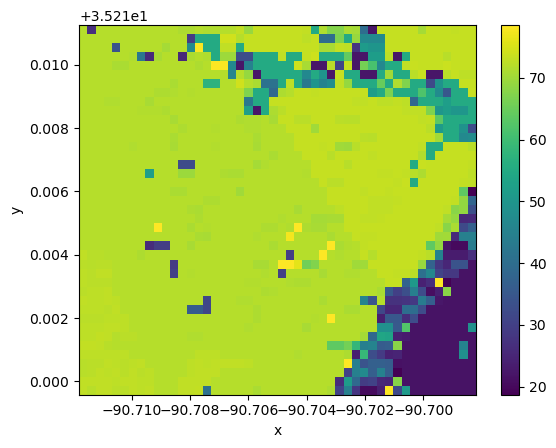

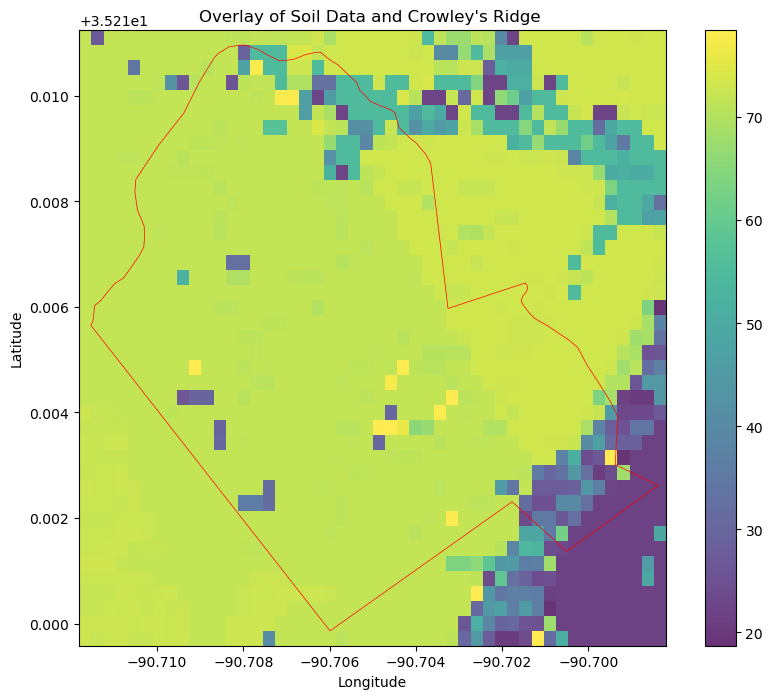

In [22]:
# Download soil data for crowley's Ridge
# Define the download URL for the study area (Polaris Data). 
crowley_soil_url_template = ("http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/silt"
            "/mean"
            "/60_100/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)

crowley_soil_url = crowley_soil_url_template.format(
    min_lat=34.5, max_lat=36.5, min_lon=-90.6, max_lon=-90.9  
)

crowley_soil_url

#Define Bounds for Crowleys Ridge
crowley_bounds = bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    crowley_gdf.total_bounds)

crowley_soil_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        crowley_soil_url = crowley_soil_url_template.format(
            min_lat=min_lat, max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1)
        crowley_soil_url_list.append(crowley_soil_url)
crowley_soil_url_list

crowley_soil_das = []

#loop through each of the soil files
for i in crowley_soil_url_list:
     # Load the raster data into Python, mask and scale and squeeze
    crowley_soil_da = rxr.open_rasterio(
         i,
         mask_and_scale=True
         ).squeeze()
    print('OPENED ')

    # Crop the raster data
    crowley_cropped_da = crowley_soil_da.rio.clip_box(*crowley_bounds) 
    crowley_soil_das.append(crowley_cropped_da)
    print('CROPPED')

# Merge tiles

# Function to convert xarray DataArray to rasterio dataset
def dataarray_to_rasterio(da):
    """Convert an xarray DataArray to a rasterio dataset stored in MemoryFile."""
    height, width = da.shape
    transform = from_bounds(*da.rio.bounds(), width, height)
    crs = da.rio.crs

    memfile = MemoryFile()
    with memfile.open(
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=da.dtype,
        crs=crs,
        transform=transform,
    ) as dataset:
        dataset.write(da.values, 1)

    return memfile.open()

# Convert all DataArrays to rasterio datasets
rasterio_datasets = [dataarray_to_rasterio(da) for da in crowley_soil_das]

# Merge using rasterio
merged_array, merged_transform = merge(rasterio_datasets)

# Ensure `y` axis is in correct order
y_coords = np.linspace(merged_transform.f, merged_transform.f + merged_array.shape[1] * merged_transform.e, merged_array.shape[1])
x_coords = np.linspace(merged_transform.c, merged_transform.c + merged_array.shape[2] * merged_transform.a, merged_array.shape[2])

# ✅ Correct CRS and Assign Transform
crowley_soil_merged_das = xr.DataArray(
    merged_array[0],  # Use the first band
    dims=("y", "x"),
    coords={"y": y_coords[::-1], "x": x_coords},  # Flip y-coordinates to correct orientation
    attrs={"crs": rasterio_datasets[0].crs, "transform": merged_transform}
)

# Plot merged raster
crowley_soil_merged_das.plot()

# # Create a plot
crowley_ridge, ax = plt.subplots(figsize=(10, 8))

# Plot the raster data (crowley_soil_das)
crowley_soil_merged_das.plot(ax=ax, cmap="viridis", alpha=0.8)  # Adjust alpha for transparency

# Plot the boundaries of the vector data (crowley_gdf)
crowley_gdf.boundary.plot(ax=ax, color='red', linewidth=.5)

# Add title and labels
ax.set_title("Overlay of Soil Data and Crowley's Ridge ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

### Topographic data

One way to access reliable elevation data is from the [SRTM
dataset](https://www.earthdata.nasa.gov/data/instruments/srtm),
available through the [earthaccess
API](https://earthaccess.readthedocs.io/en/latest/quick-start/).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download SRTM elevation data for a particular location and
calculate any additional topographic variables you need such as slope or
aspect.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include topographic parameters that will help you
to answer your scientific question.</p></div></div>

> **Warning**
>
> Be careful when computing the slope from elevation that the units of
> elevation match the projection units (e.g. meters and meters, not
> meters and degrees). You will need to project the SRTM data to
> complete this calculation correctly.

In [23]:
# Download elevation data
# Define data directory for 
crowley_elevation_dir = os.path.join(data_dir, 'crowley_elevation_strm')

os.makedirs(crowley_elevation_dir, exist_ok=True)

In [24]:
# Log in to earthaccess
earthaccess.login()

In [25]:
# Search earthaccess for datasets 
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
SRTMIMGM NASA Shuttle Radar Topography Mission Combined Image Data Set V003
SRTMIMGR NASA Shuttle Radar Topography Mission Swath Image Data V003
GFSAD30EUCEARUM

# Crowley's Ridge

In [31]:
# Define data search for Crowley's Ridge# I feel there is a way to make this a function but I am running out of time

# Define bounds for Crowley's Ridge
bounds_crowley = tuple(crowley_gdf.total_bounds)
buffer = .05 
xmin, ymin, xmax, ymax = bounds_crowley
bounds_crowley_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

if not glob(crowley_srtm_pattern):
    crowley_srtm_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds_crowley_buffer
    )
    crowley_srtm_results = earthaccess.download(crowley_srtm_results, crowley_elevation_dir)
else:
    print("Files already exist. Skipping download.")

Files already exist. Skipping download.


In [32]:
# Create a list
crowley_srtm_da_list = []
bounds_crowley_buffer = tuple(crowley_gdf.total_bounds)
for crowley_srtm_path in glob(crowley_srtm_pattern):
    tile_da = rxr.open_rasterio(crowley_srtm_path, mask_and_scale=True).squeeze()
    
    # Crop data arrays
    crowley_cropped_da = tile_da.rio.clip_box(*bounds_crowley_buffer) 
    crowley_srtm_da_list.append(crowley_cropped_da)

# Merge tiles
crowley_srtm_da = rxrmerge.merge_arrays(crowley_srtm_da_list)

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

# Plot the DataArray
crowley_srtm_da.plot(ax=ax)

# Plot the habitat1 boundary on the same axis
crowley_gdf.boundary.plot(ax=ax, color='yellow', linewidth=0.5)

# Add a title and axis labels
ax.set_title('SRTM Elevation Data with Crowleys Ridge', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

NoDataInBounds: No data found in bounds.

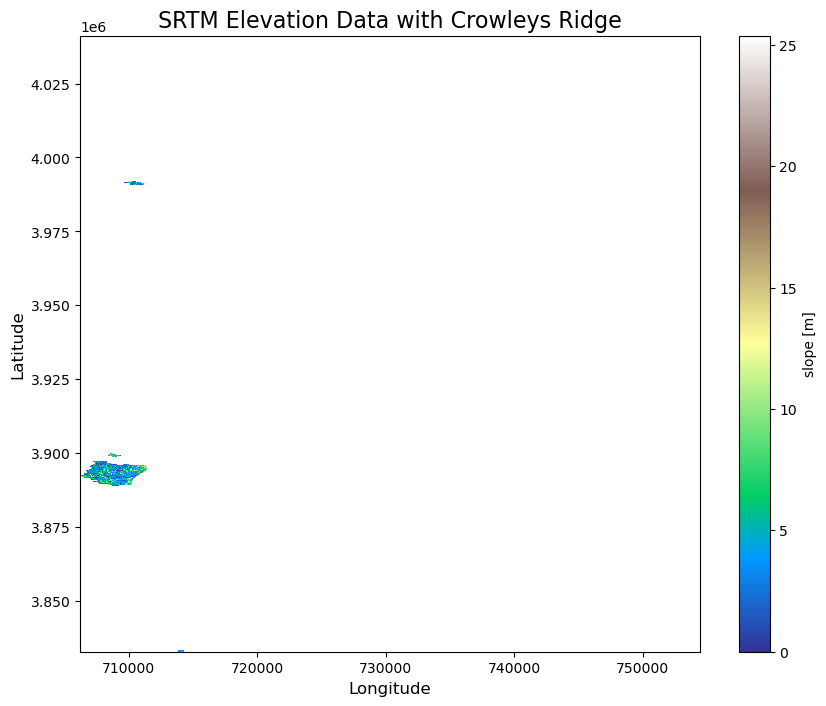

In [9]:
# Reproject and calculate slope 
# Find the UTM zone using https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#
# Crowley's Ridge is in UTM 15
utm15_epsg = 32615
crowley_srtm_project_da = crowley_srtm_da.rio.reproject(32615)
crowley_proj_gdf = crowley_gdf.to_crs(utm15_epsg)

# Calculate slope
crowley_slope_full_da = xrspatial.slope(crowley_srtm_project_da)

# Clip the slope data by the crowley boundaries
crowley_slope_da = crowley_slope_full_da.rio.clip(crowley_proj_gdf.geometry)

# Create a figure and axes to ensure consistent plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the slope data
crowley_slope_da.plot(ax=ax, cmap='terrain')

# Add a title and labels after plotting
ax.set_title('SRTM Elevation Data with Crowleys Ridge', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()

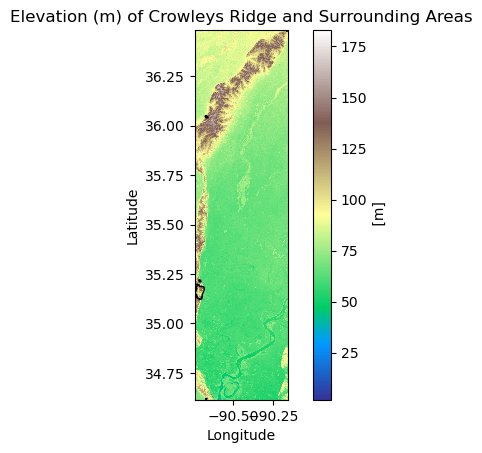

In [18]:
# Calculate the slope
crowley_slope_da = xrspatial.slope(crowley_srtm_project_da)

# Initialize a figure and axis
# fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust the figure size

# Add the Habitat 1 boundary
# crowley_gdf.to_crs(utm15_epsg).boundary.plot(ax=ax, color='black', linewidth=.5)

# Check SRTM data w/Crowley's Ridge plotted on top
crowley_srtm_da.plot(cmap='terrain')

crowley_gdf.boundary.plot(ax = plt.gca(), color='black', linewidth=1)
plt.title('Elevation (m) of Crowleys Ridge and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()


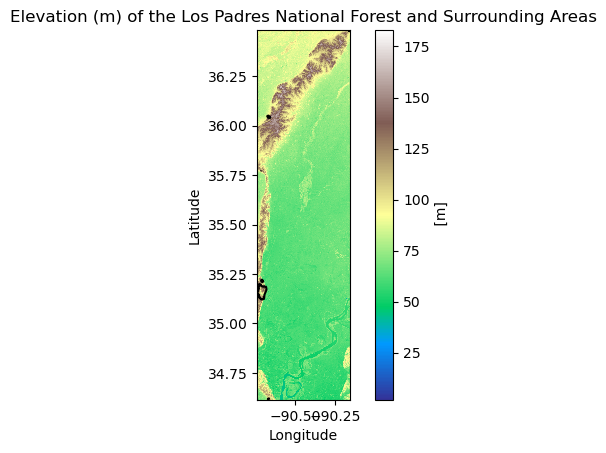

In [12]:
# Store the essential information to import into the next notebook
%store crowley_gdf crowley_srtm_da

Stored 'crowley_gdf' (GeoDataFrame)
Stored 'crowley_srtm_da' (DataArray)
